<a href="https://colab.research.google.com/github/atharv946/Chromatin-Accessibility/blob/main/Step5a_CNN_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

import pandas as pd

from keras.models import Sequential

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from keras.optimizers import Adam

from keras.preprocessing.sequence import pad_sequences

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/1:1_Atharv_Gupta/Datasets/joined_train_random_1k.csv')
df_val = pd.read_csv('/content/drive/MyDrive/1:1_Atharv_Gupta/Datasets/joined_valid_random_1k.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function to one-hot encode a sequence

def one_hot_encode(sequence, max_length):

    encoding = {'A': [1, 0, 0, 0],

                'C': [0, 1, 0, 0],

                'G': [0, 0, 1, 0],

                'T': [0, 0, 0, 1],

                'N': [0, 0, 0, 0]

                }

    # One-hot encode the sequence

    encoded_sequence = [encoding.get(base, [0, 0, 0, 0]) for base in sequence[:max_length]]

    # Pad to the maximum length by adding [0, 0, 0, 0] (which represents 'N' or padding)

    return pad_sequences([encoded_sequence], maxlen=max_length, dtype='int32', padding='post')[0]

In [ ]:
# Set the fixed sequence length
fixed_length = 1000


# One-hot encode all sequences in the DataFrame and truncate/pad to fixed length
X_train = np.array([one_hot_encode(seq, fixed_length) for seq in df_train['sequence']])

In [ ]:
y_train  = np.array(df_train['accessibility'])

In [ ]:
X_val = np.array([one_hot_encode(seq, fixed_length) for seq in df_val['sequence']])

In [ ]:
y_val = np.array(df_val['accessibility'])

In [ ]:
import tensorflow as tf

from tensorflow.keras import layers, models, Input



def create_cnn_transformer_model(input_shape):

    # Input layer
    inputs = Input(shape=(1000, 4, 1))

    # CNN Layers
    x = layers.Conv2D(filters=64, kernel_size=(13,4), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(filters=64, kernel_size=(13,1), activation='relu', padding='same')(x)
    #x = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = layers.MaxPooling2D(pool_size=(5,1))(x)
    # Add more CNN layers as needed
    x = layers.Conv2D(filters=64, kernel_size=(7,1), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=64, kernel_size=(7,1), activation='relu', padding='same')(x)
    #x = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = layers.MaxPooling2D(pool_size=(5,1))(x)

    x = layers.Conv2D(filters=64, kernel_size=(5,1), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=64, kernel_size=(5,1), activation='relu', padding='same')(x)
    # x = layers.MaxPooling2D(pool_size=(5,1))(x)

    # x = layers.Flatten()(x)
    # x = layers.Dropout(0.5)(x)


    # Prepare data for Transformer (Flatten and reduce dimensions)
    # x = layers.Dense(units=128, activation='relu')(x)


    # Reshape for Transformer compatibility
    # x = layers.Reshape(target_shape=(-1, 128))(x)


    # Transformer Block (using MultiHeadAttention)

    # The input here is reshaped to match the required shape for attention
    x = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    # Add a Dense layer to process attention output
    # x = layers.MaxPooling2D(pool_size=(5,1))(x)

    x = layers.Flatten()(x)

    x = layers.Dense(units=64, activation='relu')(x)

    x = layers.Dense(units=32, activation='relu')(x)


    # Classification Head
    classification_output = layers.Dense(1, activation='sigmoid', name='classification_output')(x)


    # Model
    model = models.Model(inputs=inputs, outputs=classification_output)

    return model

In [ ]:
# Define input shape according to your data

input_shape = X_train.shape[1:]

model = create_cnn_transformer_model(input_shape)


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
# Summary of the model

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1000, 4, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 1000, 4, 64)    │          3,392 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 1000, 4, 64)    │         53,312 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 200, 4, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 200, 4, 64)     │         28,736 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 200, 4, 64)     │         28,736 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 40, 4, 64)      │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 40, 4, 64)      │         20,544 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 40, 4, 64)      │         20,544 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 40, 4, 64)      │         66,368 │ conv2d_5[0][0],        │
│ (MultiHeadAttention)      │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 10240)          │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │        655,424 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          2,080 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ classification_output     │ (None, 1)              │             33 │ dense_1[0][0]          │
│ (Dense)                   │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 879,169 (3.35 MB)

 Trainable params: 879,169 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_trained = model.fit(X_train, y_train, epochs=15, batch_size=8, validation_data=(X_val, y_val), verbose=1)

Epoch 1/15
14567/14567 ━━━━━━━━━━━━━━━━━━━━ 164s 11ms/step - accuracy: 0.5919 - loss: 0.6422 - val_accuracy: 0.7359 - val_loss: 0.5230
Epoch 2/15
14567/14567 ━━━━━━━━━━━━━━━━━━━━ 145s 10ms/step - accuracy: 0.8225 - loss: 0.3872 - val_accuracy: 0.8506 - val_loss: 0.3513
Epoch 3/15
14567/14567 ━━━━━━━━━━━━━━━━━━━━ 202s 10ms/step - accuracy: 0.8794 - loss: 0.2812 - val_accuracy: 0.8968 - val_loss: 0.2535
Epoch 4/15
14567/14567 ━━━━━━━━━━━━━━━━━━━━ 201s 10ms/step - accuracy: 0.8994 - loss: 0.2414 - val_accuracy: 0.9053 - val_loss: 0.2329
Epoch 5/15
14567/14567 ━━━━━━━━━━━━━━━━━━━━ 201s 10ms/step - accuracy: 0.9165 - loss: 0.2063 - val_accuracy: 0.9129 - val_loss: 0.2208
Epoch 6/15
14567/14567 ━━━━━━━━━━━━━━━━━━━━ 201s 10ms/step - accuracy: 0.9287 - loss: 0.1805 - val_accuracy: 0.9138 - val_loss: 0.2163
Epoch 7/15
14567/14567 ━━━━━━━━━━━━━━━━━━━━ 200s 10ms/step - accuracy: 0.9382 - loss: 0.1607 - val_accuracy: 0.9144 - val_loss: 0.2148
Epoch 8/15
14567/14567 ━━━━━━━━━━━━━━━━━━━━ 143s 10ms/s

In [ ]:
import matplotlib.pyplot as plt



def plot_history(model):

    # Plot training & validation accuracy values

    plt.figure(figsize=(14, 5))



    # Accuracy subplot

    plt.subplot(1, 2, 1)

    plt.plot(model.history['accuracy'], label='Train Accuracy')

    plt.plot(model.history['val_accuracy'], label='Validation Accuracy')

    plt.title('Model Accuracy')

    plt.xlabel('Epoch')

    plt.ylabel('Accuracy')

    plt.legend(loc='upper left')



    # Loss subplot

    plt.subplot(1, 2, 2)

    plt.plot(model.history['loss'], label='Train Loss')

    plt.plot(model.history['val_loss'], label='Validation Loss')

    plt.title('Model Loss')

    plt.xlabel('Epoch')

    plt.ylabel('Loss')

    plt.legend(loc='upper left')



    plt.tight_layout()

    plt.show()

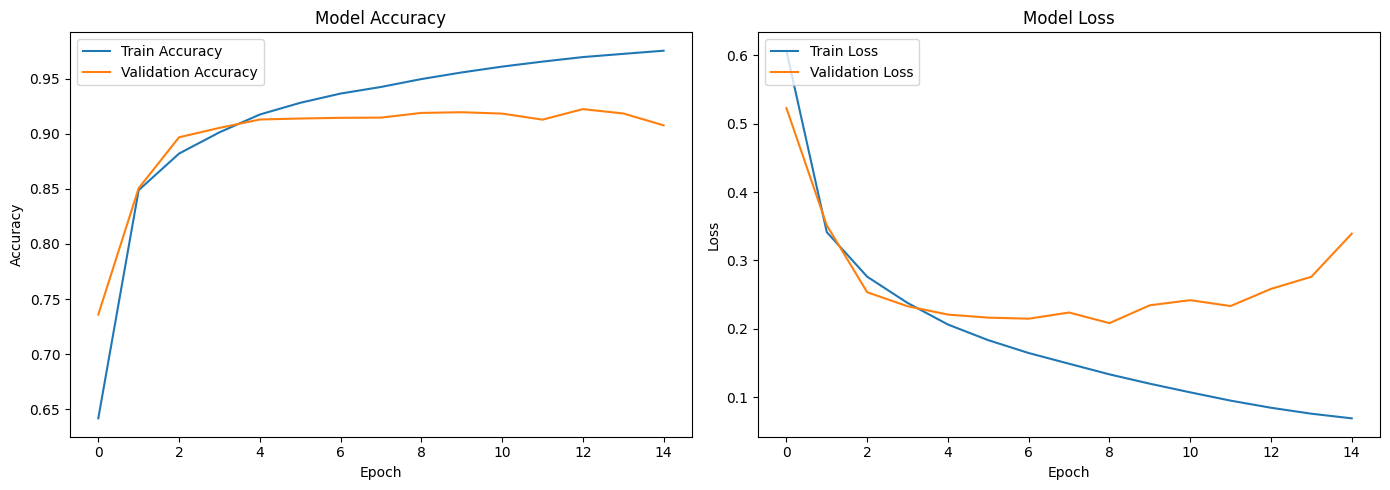

456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9069 - loss: 0.3419
Accuracy on validation set: 90.759938955307%


In [ ]:
plot_history(model_trained)# Evaluate the model on the test dataset

val_score = model.evaluate(X_val, y_val, verbose=1)

print(f'Accuracy on validation set: {val_score[1] * 100}%')

In [ ]:
# After finding optimized paramaters(learning rates and epochs) run this cell to save best model

model.save("/content/drive/MyDrive/1:1_Atharv_Gupta/Models/best_model_CNN_with_attention.h5")